<a href="https://colab.research.google.com/github/ldaniel-hm/eml_approximate/blob/main/AproximacionFuncionesLineales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aproximación de Funciones**

En este notebook se muestra cómo calcular una función aproximada de la función de evaluación de estado-acción, usando una aproximación lineal.  
   Asumimos que
   $$
   \widehat{q}(s, a, \mathbf{w}) \;=\; \mathbf{w}^\top \mathbf{x}(s, a),
   $$
   donde $\mathbf{x}(s, a)$ es un **vector de características**.
   
Vamos a suponer que el vecgor de características viene dado por Tile Coding y Se indica una posible solución en el entorno Gymnasium.


## **Tile Coding**

Tile Coding divide el espacio de estados  en regiones o "tiles" (azulejos).
Cada división recibe el nombre mosaicos (rejillas o tiling).

La idea principal es cubrir el espacio de estados con varias rejillas (tilings) que se superponen. Cada rejilla divide el espacio en celdas (tiles) y está ligeramente desplazada respecto a las otras. Esto permite que cada punto del espacio se asocie a varios tiles, uno por cada rejilla.



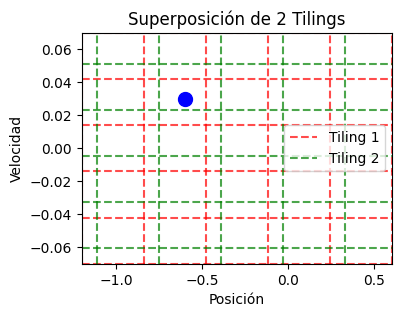

In [1]:
#@title Por ejemplo, podemos generar 2 tilings sbore el espacio $[-1.2, 0.6]\times [-0.07, 0.07]$ Cada color es un mosaico.

import numpy as np
import matplotlib.pyplot as plt

# Parámetros del espacio
x_min, x_max = -1.2, 0.6    # Rango para la posición
y_min, y_max = -0.07, 0.07  # Rango para la velocidad

# Número de celdas en cada dimensión y tilings
num_cells = 5       # se dividen en 5 celdas (25 posibles regiones)
num_tilings = 2     # cantidad de tilings

# Tamaño de cada celda
dx = (x_max - x_min) / num_cells
dy = (y_max - y_min) / num_cells

# Colores para cada tiling
colors = ['red', 'green', 'blue', 'orange']

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("Posición")
ax.set_ylabel("Velocidad")
ax.set_title("Superposición de 2 Tilings")

# Dibujar cada tiling con un offset progresivo
for i in range(num_tilings):
    # Calcular el offset para este tiling (una fracción del tamaño de celda)
    offset_x = (i / num_tilings) * dx
    offset_y = (i / num_tilings) * dy

    # Calcular las posiciones de las líneas de la grilla para cada tiling.
    # Se extiende ligeramente el rango para que se vean las líneas desplazadas.
    x_lines = np.arange(x_min + offset_x/(i+1), x_max + dx, dx)
    y_lines = np.arange(y_min + offset_y-offset_y/((2*i+1)), y_max + dy, dy)

    # Dibujar líneas verticales
    for xv in x_lines:
        ax.axvline(x=xv, color=colors[i], linestyle='--', alpha=0.7, label=f'Tiling {i+1}' if xv==x_lines[0] else "")
    # Dibujar líneas horizontales
    for yv in y_lines:
        ax.axhline(y=yv, color=colors[i], linestyle='--', alpha=0.7)

# Mostrar leyenda (cada tiling se etiqueta una sola vez)
ax.legend()

plt.scatter(-0.6, 0.03, color='blue', s=100)  # s es el tamaño del punto
plt.show()



Para un estado dado, representado con un punto, se determina en qué teselas cae en cada una de las rejillas. Esto permite definir un vector binario (o vector de características), $\mathbf{x}(s, a)$, donde cada componente indica si un tile específico está activo (por ejemplo, con valor 1) o no (valor 0).
La mayoría de componentes son 0 y unas pocas son 1, correspondientes a los tiles activos).

## **Preparamos el entorno MountainCar que se usará en el notebook**


In [2]:
#@title Importamos las librerias necesarias
import random
import gymnasium as gym
from gymnasium import ObservationWrapper
from tqdm import tqdm

In [3]:
#@title Cargamos el entorno
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset()

(array([-0.5975165,  0.       ], dtype=float32), {})

## Este es el entorno

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
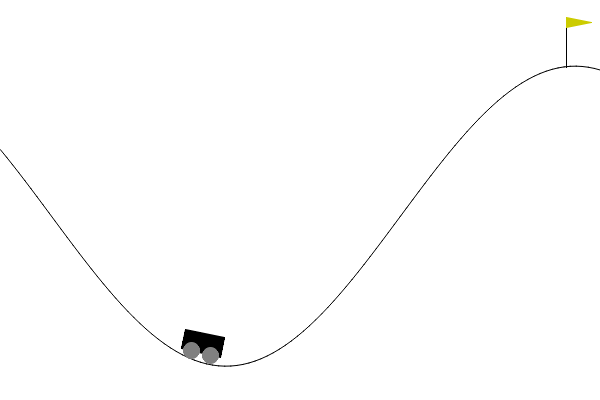

In [4]:
env.render()

### **Las acciones del entorno**

La acciones disponibles son:
- 0: Acelerar a la izquierda.
- 1: No acelerar
- 2: Acelerar a la derecha

In [5]:
env.action_space

Discrete(3)

### **Los estados del entorno**

Las observaciones es un ndarray con dimensión (2,) donde los elementos se corresponde a los siguientes valores:

| Número | Observación                          | Mínimo | Máximo | Unidad        |
|--------|--------------------------------------|--------|--------|---------------|
| 0      | Posición del coche en el eje x      | -1.2   | 0.6    | posición (m)  |
| 1      | Velocidad del coche                 | -0.07  | 0.07   | velocidad (v) |


In [6]:
env.observation_space, env.observation_space.low,  env.observation_space.high

(Box([-1.2  -0.07], [0.6  0.07], (2,), float32),
 array([-1.2 , -0.07], dtype=float32),
 array([0.6 , 0.07], dtype=float32))

<br><br><br><br>

## **Creamos una Tile Coding para los estados de MountainCar**

- Necesitamos hacer un Wrapper sobre el espacio de observaciones
- Vamos a generar varios tilings (mosaicos).

In [7]:
#@title Extensión de la clase ObservationWrapper de Gymnasium para discretizar estados continuos

env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset(seed=10)

# https://gymnasium.farama.org/tutorials/gymnasium_basics/implementing_custom_wrappers/


# Definimos una clase que hereda de gym.ObservationWrapper, la cual nos permite modificar las observaciones que devuelve el entorno.

class TileCodingEnv(ObservationWrapper):
    """
    TileCodingEnv es un envoltorio para un entorno Gym que aplica la técnica de Tile Coding.
    Esta técnica discretiza observaciones continuas en múltiples rejillas (tilings) desplazadas,
    permitiendo representar el espacio de estados de forma que se faciliten la generalización y el aprendizaje.
    """

    def __init__(self, env, bins, low, high, n=4):
        """
        Inicializa el entorno env con tile coding.

        Parámetros:
        - env: entorno original de Gym.
        - bins: array o lista con el número de intervalos (bins) que hay que particionar cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - n: número de tilings (rejillas) a crear (por defecto 4).

        Se llama al método _create_tilings para generar las rejillas desplazadas.
        """
        super().__init__(env)  # Llama al constructor de la clase padre ObservationWrapper.

        # Guardamos atributos útiles para calcular las features solo una vez.
        self.bins = bins              # Ej.: np.array([10, 10])
        self.n_tilings = n            # Número de tilings.
        self.tile_size = int(np.prod(bins))  # Número de celdas en cada tiling.
        self.last_active_features = None     # Aquí se guardarán las features activas de la última observación

        self._high = high
        self._low = low

        self.tilings = self._create_tilings() # (bins, high, low, n)  # Crea y almacena las tilings.

        # el vector de observación tendrá C componentes. Por ejemplo, para 2 dimensiones × 4 tilings = C = 8.
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist()*n)



    def observation(self, obs):  # Es necesario sobreescribir este método de ObservationWrapper
        """
        Transforma una observación continua en una representación discreta usando tile coding.

        Parámetro:
        - obs: observación continua proveniente del entorno.

        Para cada tiling en self.tilings, se determina el índice (bin) para cada dimensión usando np.digitize.
        Se devuelve una lista de tuplas de índices, una por cada tiling.
        Antes de retornar, se calcula y almacena en self.last_active_features el conjunto de índices
        activos (flattened) usando _get_active_features().

        Retorna:
        - indices: lista de tuplas de índices, una por cada tiling.

        """
        indices = []  # Lista que almacenará los índices discretizados para cada tiling.
        for t in self.tilings:
            # Para cada tiling 't', se calcula el índice en el que se encuentra cada componente de la observación.
            tiling_indices = tuple(np.digitize(i, b) for i, b in zip(obs, t))
            indices.append(tiling_indices)  # Se agrega la tupla de índices correspondiente a la tiling actual.

        # Calcula y guarda las features activas a partir de los índices obtenidos.
        self.last_active_features = self._get_active_features(indices)
        return indices # Retorna la lista de índices de todas las tilings.


    def _get_active_features(self, tiles):
        """
        Método privado para calcular los índices (features) activos en la función aproximada.

        Parámetro:
        - tiles: lista de tuplas (una por tiling) obtenida de observation(), donde cada tupla
          contiene los índices discretizados para cada dimensión.

        La función realiza lo siguiente:
          1. Convierte cada tupla de índices a un índice plano usando np.ravel_multi_index(tile, bins).
            - Dado que `tile` es una tupla de índices - por ejemplo, `(3, 5)` , y
            - dado que `bins` indica las particiones en cada dimensión - por ejemplo `bins = [10, 10]``
            - entonces `(3, 5)` se mapea a  3*10 + 5 = 35
            - Este índice plano identifica de forma única una celda dentro de una tiling.

          2. Asigna a cada tiling un bloque distinto en el vector de parámetros, de forma que:
             feature = (índice del tiling * tile_size) + índice plano.
             - Por ejemplo, con dos tilings, si en ambos se selecccionara el tile `(3, 5)`
             - Para el tiling 0 (i = 0), el flat_index será 35 (como se ha calculado antes)
             - Pero para el tiling 1 (i=1), el flat_index será 1*100+35=135

        Retorna:
        - features: lista de índices únicos (enteros) que indican las características activas.
        """
        features = []
        for i, tile in enumerate(tiles):
            # Convierte la tupla 'tile' a un índice plano.
            flat_index = np.ravel_multi_index(tile, self.bins)
            # Asigna a cada tiling un bloque único: para el tiling i, los índices van desde i*tile_size hasta (i+1)*tile_size - 1.
            feature = i * self.tile_size + flat_index
            features.append(feature)
        return features



    def _create_tilings(self): # , bins, high, low, n):
        """
        Crea 'n' tilings (rejillas) desplazadas para el tile coding.

        Parámetros:
        - bins: número de intervalos (bins) en cada dimensión.
        - high: array con el límite superior para cada dimensión.
        - low: array con el límite inferior para cada dimensión.
        - n: número de tilings a crear.

        El proceso consiste en:
         1. Generar un vector de desplazamientos base (displacement_vector) para cada dimensión.
         2. Para cada tiling, se ajustan los límites 'low' y 'high' añadiéndoles un pequeño desplazamiento aleatorio.
         3. Se calculan los tamaños de los segmentos en cada dimensión (segment_sizes).
         4. Se determinan desplazamientos específicos para cada dimensión y se aplican a los límites.
         5. Finalmente, se generan los buckets (límites discretos) para cada dimensión usando np.linspace.

        Retorna:
        - tilings: una lista donde cada elemento es una tiling (lista de arrays de buckets para cada dimensión).
        """
        # Se genera un vector de desplazamientos en cada dimensión en base a los números impares.
        # P.e. Si hay 2 dimensiones (len(bins) == 2): np.arange(1, 2 * 2, 2) -> np.arange(1, 4, 2) devuelve [1, 3]
        #      Si la dimensión 1 se desplaza en 1 unidad, en la dimensión 2 se desplazará en 3 unidades.
        # P.e. Si hay 3 dimensiones (len(bins) == 3): np.arange(1, 2 * 3, 2) -> np.arange(1, 6, 2) devuelve [1, 3, 5]
        # P.e. Si hay 4 dimensiones (len(bins) == 4): np.arange(1, 2 * 4, 2) -> np.arange(1, 8, 2) devuelve [1, 3, 5, 7]
        # Y así sucesivamente.
        # displacement_vector se ajusta automáticamente generando un array de números impares
        # Estos valores se usan posteriormente para calcular los desplazamientos específicos en cada dimensión al crear las tilings (rejillas).
        # ¿Por qué esos valores? Porque son los recomendados: los primeros números impares.
        displacement_vector = np.arange(1, 2 * len(bins), 2)


        tilings = []  # Lista que almacenará todas las tilings generadas.
        for i in range(0, self.n_tilings):
            # Para cada tiling 'i', se calculan nuevos límites 'low_i' y 'high_i' con un desplazamiento aleatorio.
            # El desplazamiento aleatorio se basa en el 20% de los límites originales.
            low_i = self._low  # - random.random() * 0.2 * low
            high_i = self._high # + random.random() * 0.2 * high

            # Vamos a calcular el desplazamiento específico para cada dimensión y cada mosaico.

            # Antes calculamos displacement_vector, que nos indica el desplazamiento en cada dimensión.
            # Como tenemos varios mosaicos, cada uno se tendrá que desplazar
            # en la mismas cantidades con respecto al mosaico anterior.
            # Esto se puede conseguir multiplicando el displacement_vector por el número de mosaico (i),
            # pero se toma el módulo n (número total de mosaicos).
            # De esta forma el desplazamiento de cada mosaico es diferente, dentro del rango [0, n-1]

            # P.e. Para n=4 mosaicos, y dos dimensiones, los vectores de desplazamiento de cada mosaico son:
            # i = 1: [1, 3] = [1, 3] * 1 % 4 = [1, 3] % 4
            # i = 2: [2, 2] = [1, 3] * 2 % 4 = [2, 6] % 4
            # i = 3: [3, 1] = [1, 3] * 3 % 4 = [3, 9] % 4
            # i = 4: [0, 0] = [1, 3] * 4 % 4 = [4, 12] % 4
            displacements = displacement_vector * i % self.n_tilings

            # Pero hay que escalar el desplazamiento a unidades reales en cada dimensión.
            # Para ello necesitamos calcular el tamaño de cada segmento (intervalo) en cada dimensión.
            segment_sizes = (high_i - low_i) / self.bins

            # Entonces usamos una fracción del tamaño del segmento para desplazar cada mosaico.
            # La fracción del tamaño del segmento viene dado por el tamaño del segmento dividido por el número de mosaicos.
            # Por ejemplo, si el tamaño de la celda es 0.5 en la primera dimensión y se consideran n=4 mosaicos, la fracción es 0.5/4=0.125
            # Según se ha calculado anteriormente, en el vector de desplazamiento,
            # la primera dimensión se desplaza en 1, 2, 3 y 0 unidades para los mosaicos 1, 2, 3, y 4, respectivamente.
            # Como la unidad es 0.125, entonces la primera dimensión de cada mosaico se desplaza en las cantidades:
            # 0.125 = 1 * 0.125,  0.25 = 2 * 0.125, 0.375 = 3 * 0.125, y  0 = 0 * 0.125.
            # Lo mismo se haría con el resto de dimensiones. En forma vectorial:
            # Es decir, el desplazamiento de cada mosaico en la primera dimensión es:
            # Tiling 1, [1, 3]: [1 * 0.125, 3 * 0.05] = [0.125, 0.15]
            # Tiling 2, [2, 2]: [2 * 0.125, 2 * 0.05] = [0.25, 0.10]
            # Tiling 3, [3, 1]: [3 * 0.125, 1 * 0.05] = [0.375, 0.05]
            # Tiling 4  [0, 0]: [0 * 0.125, 0 * 0.05] = [0, 0]
            displacements = displacements * (segment_sizes / self.n_tilings)

            dlow_i = low_i + displacements
            dhigh_i = high_i + displacements
            # print(f"Tiling {i}: Se aplican los desplazamientos {displacements} a los límites inferiores {low_i}->{dlow_i} y superiores {high_i}->{dhigh_i}.")

            # Para cada dimensión, se crean los buckets que dividen el intervalo de low_i a high_i en 'bins' partes,
            # generando 'l-1' puntos (límites) para cada dimensión.
            buckets_i = [np.linspace(j, k, l - 1) for j, k, l in zip(dlow_i, dhigh_i, bins)]

            # Se añade la tiling actual (lista de buckets para cada dimensión) a la lista de tilings.
            tilings.append(buckets_i)

        return tilings  # Retorna la lista completa de tilings.

In [8]:
#@title Generamos  mosaicos (tilings) con varios intervalos por dimensión. Al nuevo espacio lo llamaremos *tcenv*
tilings = 10  # Número de mosaicos
bins = np.array([20, 20])  # Número de intervalos en cada dimensión. 20 en cada una
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

In [9]:
#@title Comparamos el entorno original con el entorno con estados agregados

print(f"El espacio de observaciones original es: {env.observation_space}, \n\
Un estado para este espacio original es: {env.step(env.action_space.sample())}")
print(f"\nEl espacio de estados modificado es: {tcenv.observation_space}. Mosaicos: {tcenv.n_tilings} \n\
Un estado para este nuevo espacio es: {tcenv.step(tcenv.action_space.sample())[0]} \n\
Cada pareja es la 'celda' correspondiente a cada mosaico")
print(f"Las caracterísiticas observadas han sido {tcenv.last_active_features} sobre {np.prod(tcenv.bins)*tcenv.n_tilings} parámetros")

El espacio de observaciones original es: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Un estado para este espacio original es: (array([-0.40964374, -0.00084407], dtype=float32), -1.0, False, False, {})

El espacio de estados modificado es: MultiDiscrete([20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]). Mosaicos: 10 
Un estado para este nuevo espacio es: [(8, 9), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (8, 8), (8, 9), (8, 9), (8, 9)] 
Cada pareja es la 'celda' correspondiente a cada mosaico
Las caracterísiticas observadas han sido [169, 569, 969, 1368, 1769, 2169, 2568, 2969, 3369, 3769] sobre 4000 parámetros


### **Cómo usar el código para obtener una aproximación de Q(s,a)**


Queremos calcular $\widehat{q}(s, a, \mathbf{w}) = \displaystyle\mathbf{w}^\top \mathbf{x}(s, a) = \sum_{i=1}^d w_i \cdot x_i(s, a)$


Para cada acción, la  función tendrá tantos pesos como el número total de tiles (celdas) generadas en todos los tilings. Por tanto, los pesos $\mathbf{w}$  se definen como una matriz de dimensiones $total\_features \times n\_actions$.

```
# Número de acciones en el entorno original
num_actions = tcenv.env.action_space.n  

# Número total de características en el aproximador lineal:
total_features = tcenv.n_tilings * np.prod(tcenv.bins)

# Inicializamos los pesos (por ejemplo, en cero)
w = np.zeros((total_features, num_actions))
```

Cada fila de `w` corresponde a una feature (un tile específico de un tiling) y cada columna a una acción.

Como las características son binarias, la evaluación de $\widehat{q}$ se reduce a sumar los pesos que se corresponde a las características activas:
$$
\widehat{q}(s, a, \mathbf{w}) = \sum_{i \in \text{features_activas}(s)} w_{i,a}.
$$



 Así, cuando estés en un estado $s$, el método `tcenv.observation(s)` (y, por extensión, `tcenv.last_active_features`) te proporcionará los índices de los tiles activos en ese estado. Por ejemplo, si `tcenv.last_active_features` retorna `[35, 142, 18, 600]` y seleccionas la acción $a$, entonces

```python
q_sa = w[35, a] + w[142, a] + w[18, a] + w[600, a]
```

Eso es lo que define y cómo se utiliza la matriz de pesos $\mathbf{w}$ según el código y la aproximación lineal con Tile Coding.

Por tanto, para calcular $\widehat{q}(s, a, \mathbf{w})$ se necesitará la siguiente función:

In [10]:
def q_value(active_features, a, weights):
    """
    Calcula q(s,a) como la suma de los pesos para los índices activos.

    Parámetros:
      - active_features: lista de índices de features activas para el estado s.
      - a: acción seleccionada.
      - weights: matriz de pesos de dimensiones [n_features, n_actions].

    Retorna:
      - q: valor aproximado de Q(s,a).
    """
    return weights[active_features, a].sum()

**Observa que la función Q(s,a, w) se ha sustituido por Q(x(s), a, w). No se usa el estado, sino sus características**

En el caso de que se necesitara conocer los distintos valores $Q(s,..)$, por ejemplo, para aplicar Q-Learning, entonces se puede usar este código:

In [11]:
def compute_q_values(active_features, num_actions, w):
    """
    Calcula Q(s,a) para todas las acciones a, dado un vector de features activas.

    Parámetros:
    - w: array 2D de dimensiones [n_features, num_actions]
    - active_features: lista/array de índices de features activas
    - num_actions: número de acciones

    Retorna:
    - q_vals: array 1D de longitud num_actions, donde q_vals[a] = Q(s,a)
    """
    q_vals = np.zeros(num_actions)
    for a in range(num_actions):
        q_vals[a] = q_value(active_features, a, w) # Invoca a la función anterior
    return q_vals

## ¿Como usarlo para SARSA o Q-Learning?


Recordemos la teoría. Supongamos que se quiere aplicar semigradiente-SARSA

1. **Regla de actualización general (semigradiente SARSA)**  
   Se usa la siguiente ecuación de actualización para los pesos $\mathbf{w}$:

   $$
   \mathbf{w} \;\leftarrow\;
   \mathbf{w}
   \;+\; \alpha \Bigl[
     R + \gamma \,\widehat{q}(S', A', \mathbf{w})
     \;-\; \widehat{q}(S, A, \mathbf{w})
   \Bigr]
   \,\nabla_{\mathbf{w}} \widehat{q}(S, A, \mathbf{w})
   $$
   
   Siendo $\alpha$ la tasa de aprendizaje, $\gamma$ el factor de descuento, y $R$ la recompensa obtenida en la transición $(S, A) \to (S', A')$.


2. **La función aproximada**  que estamos asumiendo es
   $
   \widehat{q}(s, a, \mathbf{w}) \;=\; \mathbf{w}^\top \mathbf{x}(s, a),
   $
   donde $\mathbf{x}(s, a)$ es un **vector de características**. Ya sabemos cómo calcular este valor.

3. **Gradiente de $\widehat{q}$**  
   Se necesita calcular $\nabla_{\mathbf{w}} \widehat{q}(S, A, \mathbf{w})$, pero  dado que $\widehat{q}$ es lineal, la derivada con respecto a $\mathbf{w}$ es simplemente:
   $$
   \nabla_{\mathbf{w}} \widehat{q}(s, a, \mathbf{w})
   \;=\;
   \mathbf{x}(s, a).
   $$
   - En Tile Coding, $\mathbf{x}(s,a)$ será  un vector con 1s en los índices de los tiles activos y 0s en el resto.

3. **Regla de actualización específica (semigradiente SARSA)**

   Al reemplazar $\nabla_{\mathbf{w}} \widehat{q}(S, A, \mathbf{w})$ por $\mathbf{x}(S, A)$, se obtiene:

   $$
   \mathbf{w}
   \;\leftarrow\;
   \mathbf{w}
   \;+\;
   \alpha \,\Bigl[
     R + \gamma \,\widehat{q}(S', A', \mathbf{w}) - \widehat{q}(S, A, \mathbf{w})
   \Bigr]
   \,\mathbf{x}(S, A).
   $$

   A menudo se define el **TD-error** $\delta$ como:
   $$
   \delta
   \;=\;
   R + \gamma \,\widehat{q}(S', A', \mathbf{w})
       - \widehat{q}(S, A, \mathbf{w}).
   $$
   Entonces, la actualización es:
   $$
   \mathbf{w}
   \;\leftarrow\;
   \mathbf{w}
   \;+\; \alpha \,\delta \,\mathbf{x}(S, A).
   $$

  Particularizando a Tile Coding:  
   - $\mathbf{x}(S,A)$ es un vector de dimensión $d$ (el total de “features” o tiles posibles).  
   - En Tile Coding, solo los tiles **activos** tienen valor 1; el resto son 0.  
   - Esto significa que, para cada transición, **solo se actualizan los pesos correspondientes a los tiles activos**.  

    En la práctica, si $\mathbf{x}(S, A)$ tuviera posiciones $\{i_1, i_2, \dots, i_k\}$ activas (con valor 1), la actualización es:
   $$
   w_{i_j}
   \;\leftarrow\;
   w_{i_j}
   \;+\; \alpha \,\delta
   \quad\text{para cada } j=1,\dots,k.
   $$

### En código (que tendrás que repasar)

```
# --- Bucle principal de entrenamiento con semigradiente SARSA ---
returns = []  # Para guardar la recompensa total de cada episodio

for episode in range(num_episodes):
    # Resetear el entorno (Gymnasium devuelve (obs, info))
    obs, info = tcenv.reset()
    # El método observation() del wrapper actualiza internamente tcenv.last_active_features.
    active_features = tcenv.last_active_features  
    # Seleccionar acción inicial usando epsilon-greedy
    a = epsilon_greedy_policy(active_features, w, num_actions, epsilon)
    
    total_reward = 0.0
    done = False

    for t in range(max_steps):
        # Ejecutar la acción 'a' y obtener la siguiente observación
        obs_next, reward, done, truncated, info = tcenv.step(a)
        total_reward += reward

        # Después de step, tcenv.last_active_features se actualiza para el nuevo estado s'
        active_features_next = tcenv.last_active_features
        
        # Seleccionar la siguiente acción a' (si el episodio continúa)
        if not (done or truncated):
            a_next = epsilon_greedy_policy(active_features_next, w, num_actions, epsilon)
        else:
            a_next = None  # No se usa si es terminal

        # Calcular Q(s,a) para el estado actual y la acción tomada
        q_sa = q_value(active_features, a, w)
        # Si no es estado terminal, calcular Q(s',a'
        if not (done or truncated):
            q_sap = q_value(active_features_next, a_next, w)
            delta = reward + gamma * q_sap - q_sa
        else:
            delta = reward - q_sa

        # Actualizar los pesos solo en las features activas para la acción 'a'
        for i in active_features:
            w[i, a] += alpha * delta

        if done or truncated:
            break

        # Actualiza estado y acción para el siguiente paso
        active_features = active_features_next
        a = a_next

    returns.append(total_reward)
    print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}")

# Después de entrenar, puedes evaluar la política (por ejemplo, sin exploración)
avg_return = np.mean(returns)
print(f"Average return over {num_episodes} episodes: {avg_return}")
```

¿Qué habría que hacer para obtener Q-Learning?


## Bibliografía

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)